In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a-c)   #개선
    sum_exp_a = sum(np.exp(a-c))
    y = exp_a/sum_exp_a
    return y

In [3]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 ONE-HOT 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [4]:
class simpleNet:
    def __init__(self):
        np.random.seed(5) #항상 동일한 랜덤값 출력을 위함 (수업 목적)
        self.W = np.random.randn(2,3) # 정규분포로 초기화 (정규분포 : 평균이 0이고 표준편차가 1인 분포값)

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t): #입력을 받아서 정답과 얼마나 차이가 나는지 보기(error)
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

2X3형태의 형상을 갖는 신경망

<img src='../images/NN.png' width=200px />

In [5]:
net = simpleNet()

In [6]:
x = np.array([0.6, 0.9]) # 입력
t = np.array([0, 0, 1]) #정답, TARGET, 정답의 확률(3개 더했을 때 총 합이 1이 나와야 함)

2개의 입력값($x_1$, $x_2$)과 3개의 정답($y_1$, $y_2$, $y_3$)

In [7]:
net.W #어떤값으로 초기화 되어있는지 확인

array([[ 0.44122749, -0.33087015,  2.43077119],
       [-0.25209213,  0.10960984,  1.58248112]])

### 입력값을 이용하여 FORWARD 방향 연산해보기

In [8]:
pred = net.predict(x)

In [9]:
print(pred)

[ 0.03785358 -0.09987323  2.88269572]


In [10]:
y = softmax(pred) 

In [11]:
print(y) # 확률로 출력

[0.05243789 0.04569106 0.90187105]


In [12]:
np.argmax(y) # y중에 값을 가장 크게 하는 index

2

In [13]:
np.argmax(t) # 정답

2

### 동일한 입력값과 정답을 이용하여 loss 구해보기

In [14]:
net.loss(x,t) # 입력 x를 넣고, target인 t를 넣으면 loss는 0.1이 나옴

0.10328361502771058

### Greadient 구해보기

In [15]:
def numerical_gradient_single_point(f, x, verbose=False): 
    h = 1e-4
    grad = np.zeros_like(x)
    if verbose:
        print('x.size={}'.format(x.size)) # (x0, x1) 을 입력으로 받음 --> 2
       
    for idx in range(x.size): #축별로 계산
        v_keep = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(v_keep) + h #n차원 입력 중 해당 차원으로만 h를 더하고
        fxh1 = f(x)
        if verbose:
            print(x, '-->', fxh1)
        
        # f(x-h) 계산
        x[idx] = float(v_keep) - h #n차원 입력 중 해당 차원으로만 h를 빼서
        fxh2 = f(x)
        if verbose:
            print(x, '-->', fxh2)
        
        grad[idx] = (fxh1 - fxh2) / (2*h) #n차원 방향의 차분을 구함 !
        x[idx] = v_keep # 값 복원
        
        if verbose:
            print('grad[{}]={}'.format(idx, grad[idx]))
            print()
    return grad

In [16]:
def numerical_gradient(f, X):
    if X.ndim == 1:
        return numerical_gradient_single_point(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = numerical_gradient_single_point(f, x)
        
        return grad

In [17]:
net.W

array([[ 0.44122749, -0.33087015,  2.43077119],
       [-0.25209213,  0.10960984,  1.58248112]])

참고) lambda <br>
&emsp;&emsp;lambda 인자리스트: 표현식

In [18]:
def f(w): #Loss 산의 높이
    return net.loss(x, t)

위처럼 해도 되지만, 아래처럼 lambda 를 써서 간단히 하는 것도 좋은 방법. 단, 인자로 들어가는 w는 dummy

In [19]:
f = lambda w: net.loss(x, t)

In [20]:
dW = numerical_gradient(f, net.W) # 6 방향의 기울기 (6개의 방향의 기울기를 구할 수 있음)

In [21]:
print(dW)

[[ 0.03146273  0.02741463 -0.05887736]
 [ 0.0471941   0.04112195 -0.08831604]]


In [22]:
net.W

array([[ 0.44122749, -0.33087015,  2.43077119],
       [-0.25209213,  0.10960984,  1.58248112]])

생각해보기
* 각 숫자들의 의미를 생각해보세요 (2020/11/24일 수업) <br>
    : net.W에서 하나의 값을 변동시키면 loss(에러)가 dW값 만큼 줄어든다. <br>
    : 예를 들어 net.W의 (1,1)에 있는 0.44의 값을 변동시키면 loss는 dW에서 net.W와 같은 위치에 있는 값인 0.03배만큼 늘어남 <br>
    : '+'는 에러가 늘어나는 값이므로 net.W 값을 줄여줘야하고 '-'는 에러가 줄어드는 값이므로 net.W 값을 늘려줘야 함
* 교재 135쪽 참조

아래와 같은 방식으로 W를 갱신할 수 있음 <br>
&emsp;&emsp; net.W = net.W - 0.01 * dW <br>
* 0.01 = learning rate

### 학습하기

In [23]:
class simpleNet2:
    def __init__(self):
        np.random.seed(0) #항상 동일한 랜덤값 출력을 위함 (수업 목적)
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss
    
    def gradient(self, x, t):
        f = lambda w: net.loss(x, t)
        dW = numerical_gradient(f, net.W) # 6 방향의 기울기
        
        return dW

In [24]:
net2 = simpleNet2()

In [25]:
net2.W

array([[ 1.76405235,  0.40015721,  0.97873798],
       [ 2.2408932 ,  1.86755799, -0.97727788]])

In [26]:
x # 입력

array([0.6, 0.9])

In [27]:
t # 정답

array([0, 0, 1])

In [28]:
net2.predict(x)

array([ 3.07523529,  1.92089652, -0.2923073 ])

In [29]:
net2.gradient(x,t) # 입력과 정답을 넣어주면 그 때의 기울기가 나옴

array([[ 0.03146273,  0.02741463, -0.05887736],
       [ 0.0471941 ,  0.04112195, -0.08831604]])

* Hyperparameters (최적화)

In [52]:
#learning_rate = 0.1
learning_rate = 0.5
steps = 100

* Train the network !

In [53]:
net2.W # train 전

array([[ 0.19091584, -0.97057437,  3.92260607],
       [-0.11881157, -0.18853937,  3.43852425]])

In [54]:
net2.loss(x, t)

0.006345425054545247

In [55]:
'''
for i in range(steps):
    grad = net2.gradient(x,t)
    print(i,grad)
'''

'\nfor i in range(steps):\n    grad = net2.gradient(x,t)\n    print(i,grad)\n'

In [56]:
vloss = np.zeros((steps, 1))

# training 
for i in range(steps):
    grad = net2.gradient(x, t) # 기울기
    net2.W = net2.W - learning_rate * grad
    
    loss_i = net2.loss(x, t)
    vloss[i] = loss_i
    #print(i, grad)
    
print('Done !')

Done !


In [57]:
net2.W # train 후

array([[-1.38222067, -2.34130594,  6.86647415],
       [-2.47851633, -2.24463674,  7.85432638]])

In [59]:
net2.loss(x, t)

9.985156233225356e-07

Text(0.5, 1.0, 'lr = 0.5')

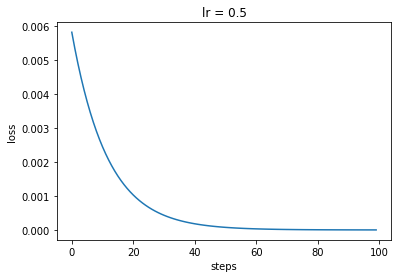

In [60]:
plt.plot(vloss)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('lr = {}'.format(learning_rate))

### Prediction / Infererence (추론과정)

In [61]:
net2.predict(x)

array([-3.0599971 , -3.42495663, 11.18877823])

In [62]:
softmax(net2.predict(x)) #확률로 계산

array([6.48388076e-07, 4.50127048e-07, 9.99998901e-01])

In [63]:
np.argmax(softmax(net2.predict(x))) #추론한 클래스

2

In [64]:
np.argmax(t) #정답 클래스

2